In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, iirnotch, filtfilt, stft
import csv

from ipywidgets import DOMWidget, widget_serialization
from matplotlib import is_interactive, rcParams
from matplotlib._pylab_helpers import Gcf
from matplotlib.backend_bases import NavigationToolbar2, _Backend, cursors
from matplotlib.backends.backend_webagg_core import (
    FigureCanvasWebAggCore,
    FigureManagerWebAgg,
    NavigationToolbar2WebAgg,
    TimerTornado,
)
%matplotlib
import ipympl



Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.signal import windows
from scipy.constants import c
from scipy.signal import stft
from scipy.signal import square
from scipy.signal import butter, iirnotch, filtfilt, correlate
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

import os
import re


In [3]:
# waterfall

def spectrogram_data(complex_data, fs):
    # Compute the Short-Time Fourier Transform (STFT)
    nperseg = 256*8  # Number of samples per segment
    noverlap = nperseg // 8  # Number of overlapping samples
    frequencies, times, Zxx = stft(complex_data, fs=fs, nperseg=nperseg, noverlap=noverlap)


    # Shift the zero frequency component to the center
    Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
    frequencies_shifted = np.fft.fftshift(frequencies)

    # Compute the magnitude of the STFT
    magnitude_spectrogram = np.abs(Zxx_shifted)
    threshold_dB = 40
    threshold = 10**(threshold_dB / 20)  # Convert dB to linear scale

    magnitude_spectrogram_db = 20 * np.log10(magnitude_spectrogram)   
    return times, frequencies_shifted, magnitude_spectrogram_db


def notch_filter(complex_data, fs):
    # Notch filter
    # Parameters
    notch_freq = 0  # Notch filter centered at 0 Hz (DC)
    quality_factor = 30  # Q-factor for the notch filter
    cutoff_freq = 0.2e6  # 
    nyquist_rate = fs / 2
    normalized_cutoff = cutoff_freq / nyquist_rate
    b, a = butter(4, normalized_cutoff, btype='high', analog=False)
    complex_data = filtfilt(b, a, complex_data)
    return complex_data


def read_iq_bin(file_path):
    # Read the binary file
    with open(file_path, 'rb') as file:
        # Read the data into a numpy array
        # The dtype should match the type of data in the file (double = float64)
        data = np.fromfile(file, dtype=np.float64)

    # Reshape or process the data if needed
    # Here we assume data was written as 2 doubles per sample
    num_new_samples = int(len(data)/2)
    data = data.reshape((num_new_samples, 2))

    # Create complex numbers from the real and imaginary parts
    complex_data = data[:, 0] + 1j * data[:, 1]
    return complex_data


def get_frame_array(directory_path):
    frames = []
    # Function to extract the numerical part from the filename
    def extract_number(filename):
        match = re.search(r'(\d+)', filename)
        return int(match.group()) if match else 0

    # List of files in the directory
    files = [f for f in os.listdir(directory_path) if f.startswith("frame") and f.endswith(".bin")]
    sorted_files = sorted(files, key=extract_number)

    for filename in sorted_files:
        if filename.startswith("frame") and filename.endswith(".bin"):
            # Read the binary file
            with open("frames/" + filename, 'rb') as file:
                data = np.fromfile(file, dtype=np.float64)

            # Reshape or process the data if needed
            # Here we assume data was written as 2 doubles per sample
            num_new_samples = int(len(data)/2)
            data = data.reshape((num_new_samples, 2))
            #print(filename)

            # Create complex numbers from the real and imaginary parts
            complex_data = data[:, 0] + 1j * data[:, 1]
                
            # Append the data to the list of frames
            frames.append(complex_data)

    return frames

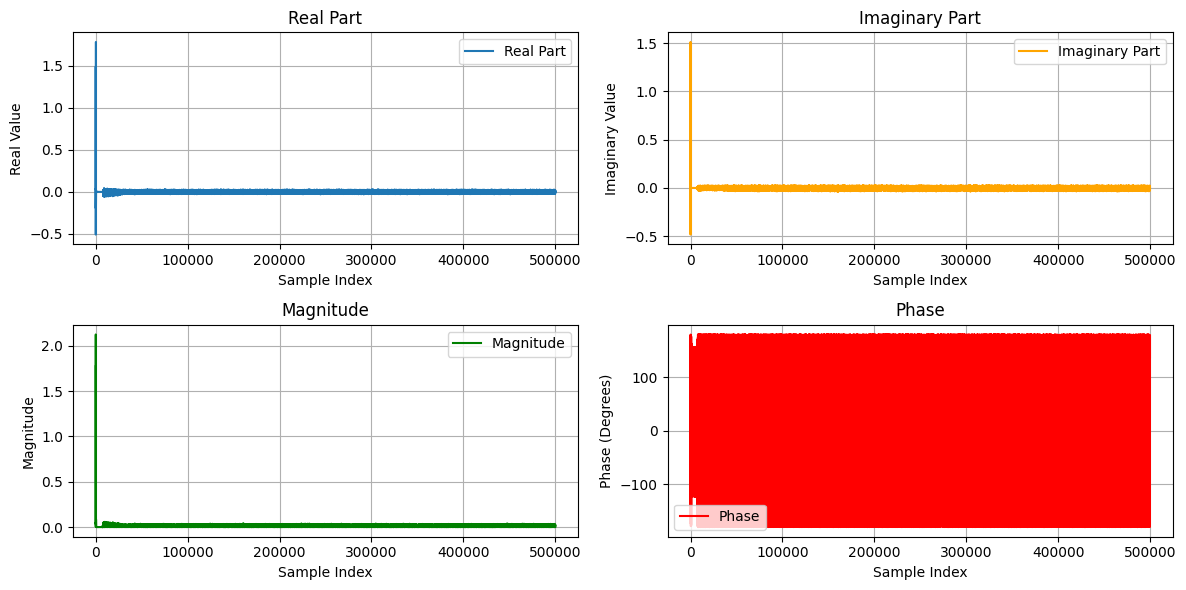

In [4]:
fs = 25e6

# Define the path to your binary file
file_path = 'matlab/outputs/pulsed_test.bin'


complex_data = read_iq_bin(file_path)
complex_data = notch_filter(complex_data, fs)


# Compute magnitude and phase
magnitudes = np.abs(complex_data)
phases = np.angle(complex_data, deg=True)  # Phase in degrees

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot real part
real = np.real(complex_data)
#real = moving_average_filter(real,10)
axs[0, 0].plot(real, label='Real Part')
axs[0, 0].set_title('Real Part')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Real Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot imaginary part
axs[0, 1].plot(np.imag(complex_data), label='Imaginary Part', color='orange')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Imaginary Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot magnitude
axs[1, 0].plot(magnitudes, label='Magnitude', color='green')
axs[1, 0].set_title('Magnitude')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot phase
axs[1, 1].plot(phases, label='Phase', color='red')
axs[1, 1].set_title('Phase')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Phase (Degrees)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


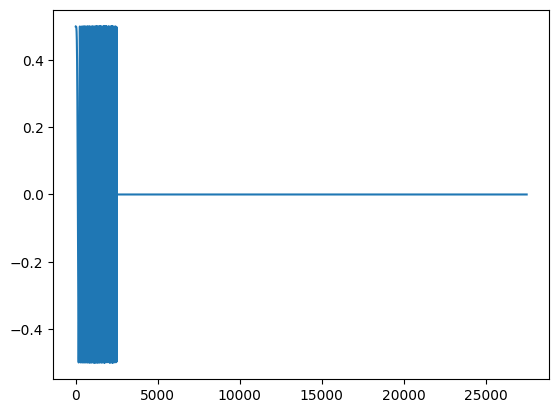

In [2]:
# write to csv for TX

# params
# relative to TX centre freq
amplitude = 0.5

sampleRate = 50e6
signalLengthTime = 1e-4
signalLength = signalLengthTime*sampleRate

signalLength = 2500 # 1ms based of 25e6 fs

startFrequency = 0
endFrequency = 2e6


result = []


for i in range(int(signalLength)):
    t = i / sampleRate
    frequency = startFrequency + (endFrequency - startFrequency) * i / signalLength
    phase = 2.0 * np.pi * frequency * t
    sample = amplitude * np.exp(1j * phase) + 0j 
    result.append(sample)

# appending zeros so transmitting is "turned off"
num_zeros = int(signalLength*10)
for i in range(num_zeros):
    result.append(0)
result = np.array(result)

# Write to CSV file
with open('sweep.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for sample in result:
        csvwriter.writerow([sample.real, sample.imag])




plt.plot(result)


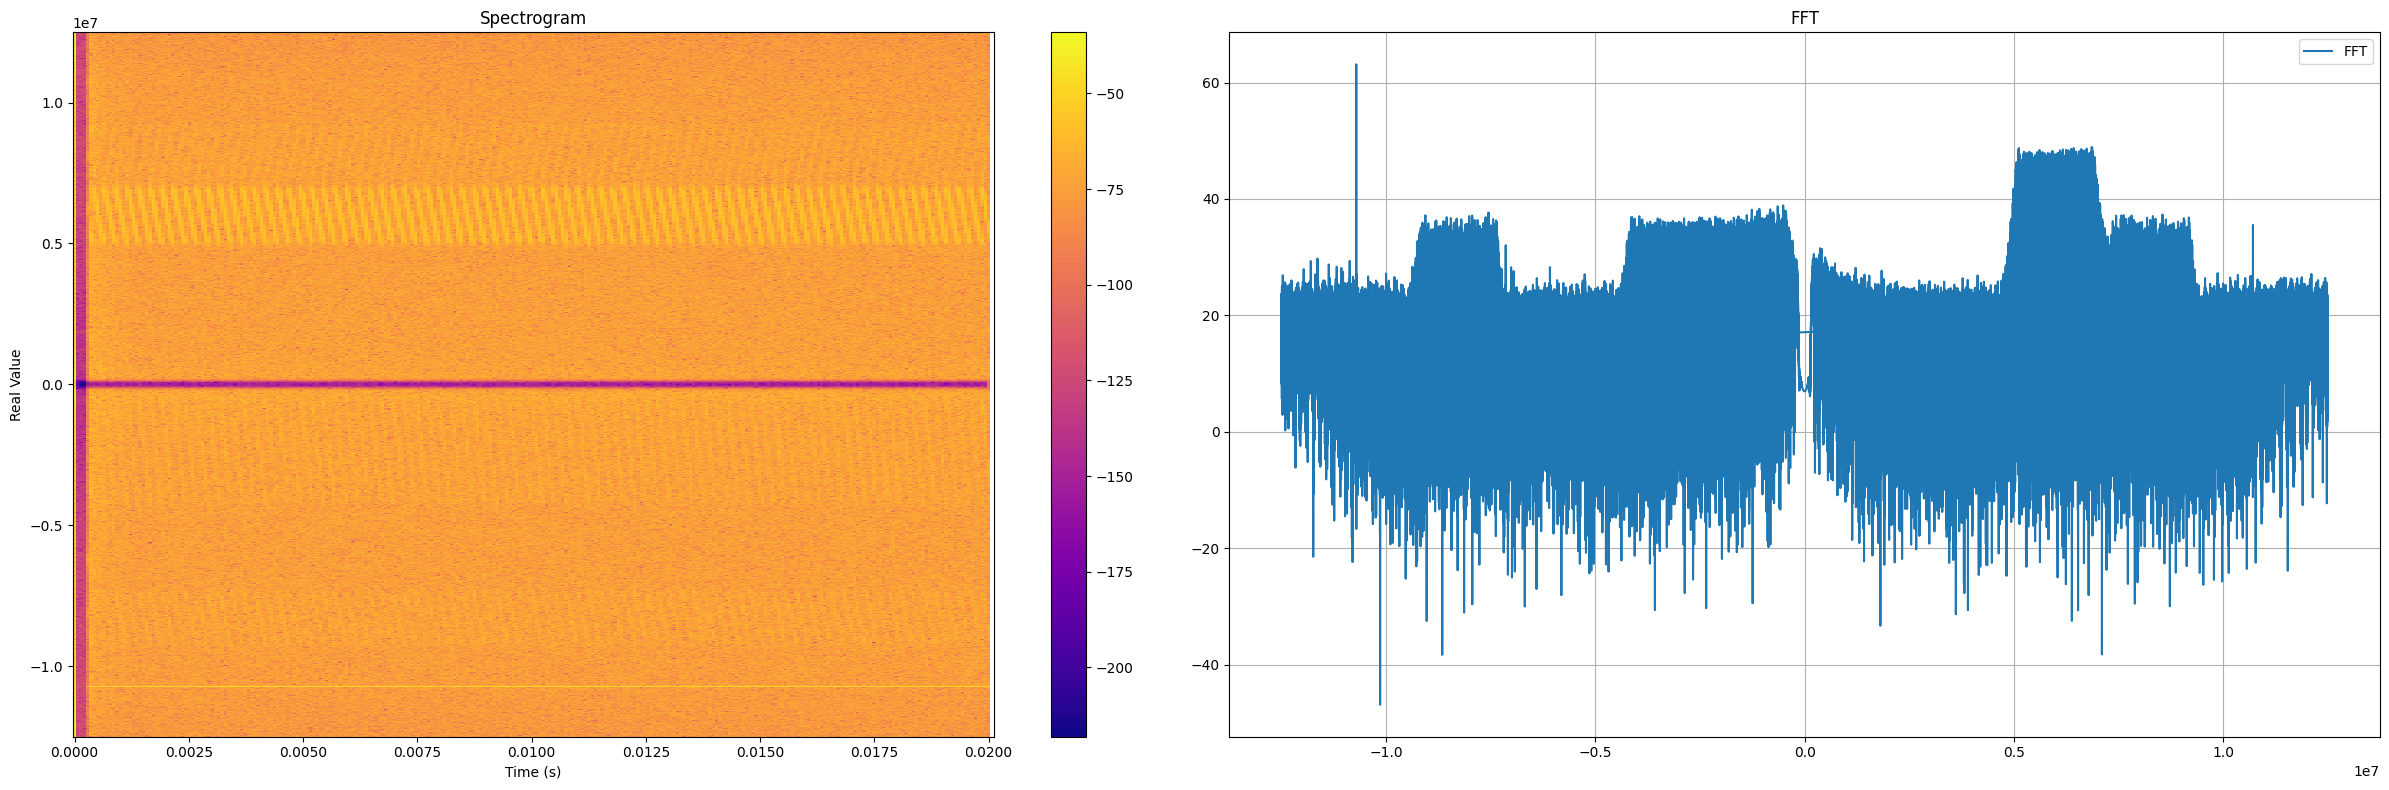

In [5]:
file_path = 'matlab/outputs/pulsed_test.bin'
fs = 25e6


complex_data = read_iq_bin(file_path)
complex_data = notch_filter(complex_data, fs)
Sr = np.abs(complex_data)**2
size = len(complex_data)
#complex_data = complex_data[int(0.0015*fs):-1]



# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Real Value')
axs[0].set_title('Spectrogram')

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
# Filter frequencies below 40 dB 
#threshold_dB = 40
#threshold = 10**(threshold_dB / 20)  # Convert dB to linear scale
#magnitude = np.where(magnitude >= threshold, magnitude, 0.1)
magnitude_db = 20 * np.log10(magnitude)




axs[1].plot(fft_freq_axis, magnitude_db, label='FFT')
axs[1].set_title('FFT')
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()


# Read the CSV file into a DataFrame with default column names (0, 1)
#df = pd.read_csv('pulse.csv', header=None)
#I = df[0].values
#Q = df[1].values
#iq_signal = I + 1j * Q
#St = np.abs(iq_signal) ** 2

#corr = np.correlate(St,Sr,mode='full')
#plt.plot(corr)


MovieWriter imagemagick unavailable; using Pillow instead.


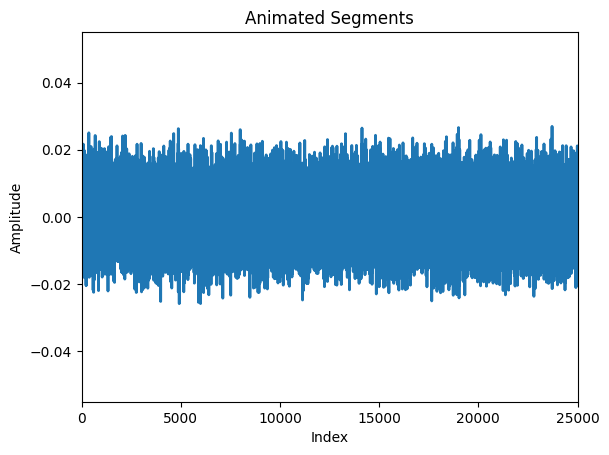

In [11]:
from matplotlib.animation import FuncAnimation
# Slice into segments of 250
segment_size = 25000
num_segments = len(complex_data) // segment_size

# Set up the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, segment_size)
#ax.set_ylim(np.min(complex_data), np.max(complex_data))
ax.set_title('Animated Segments')
ax.set_xlabel('Index')
ax.set_ylabel('Amplitude')

# Initialize the plot
def init():
    line.set_data([], [])
    return line,

# Update function for animation
def update(frame):
    segment = complex_data[frame * segment_size : (frame + 1) * segment_size]
    line.set_data(np.arange(segment_size), segment)
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=num_segments, init_func=init, blit=True, repeat=True)

# Save as GIF
ani.save('radar_segments.gif', writer='imagemagick', fps=1)

plt.show()

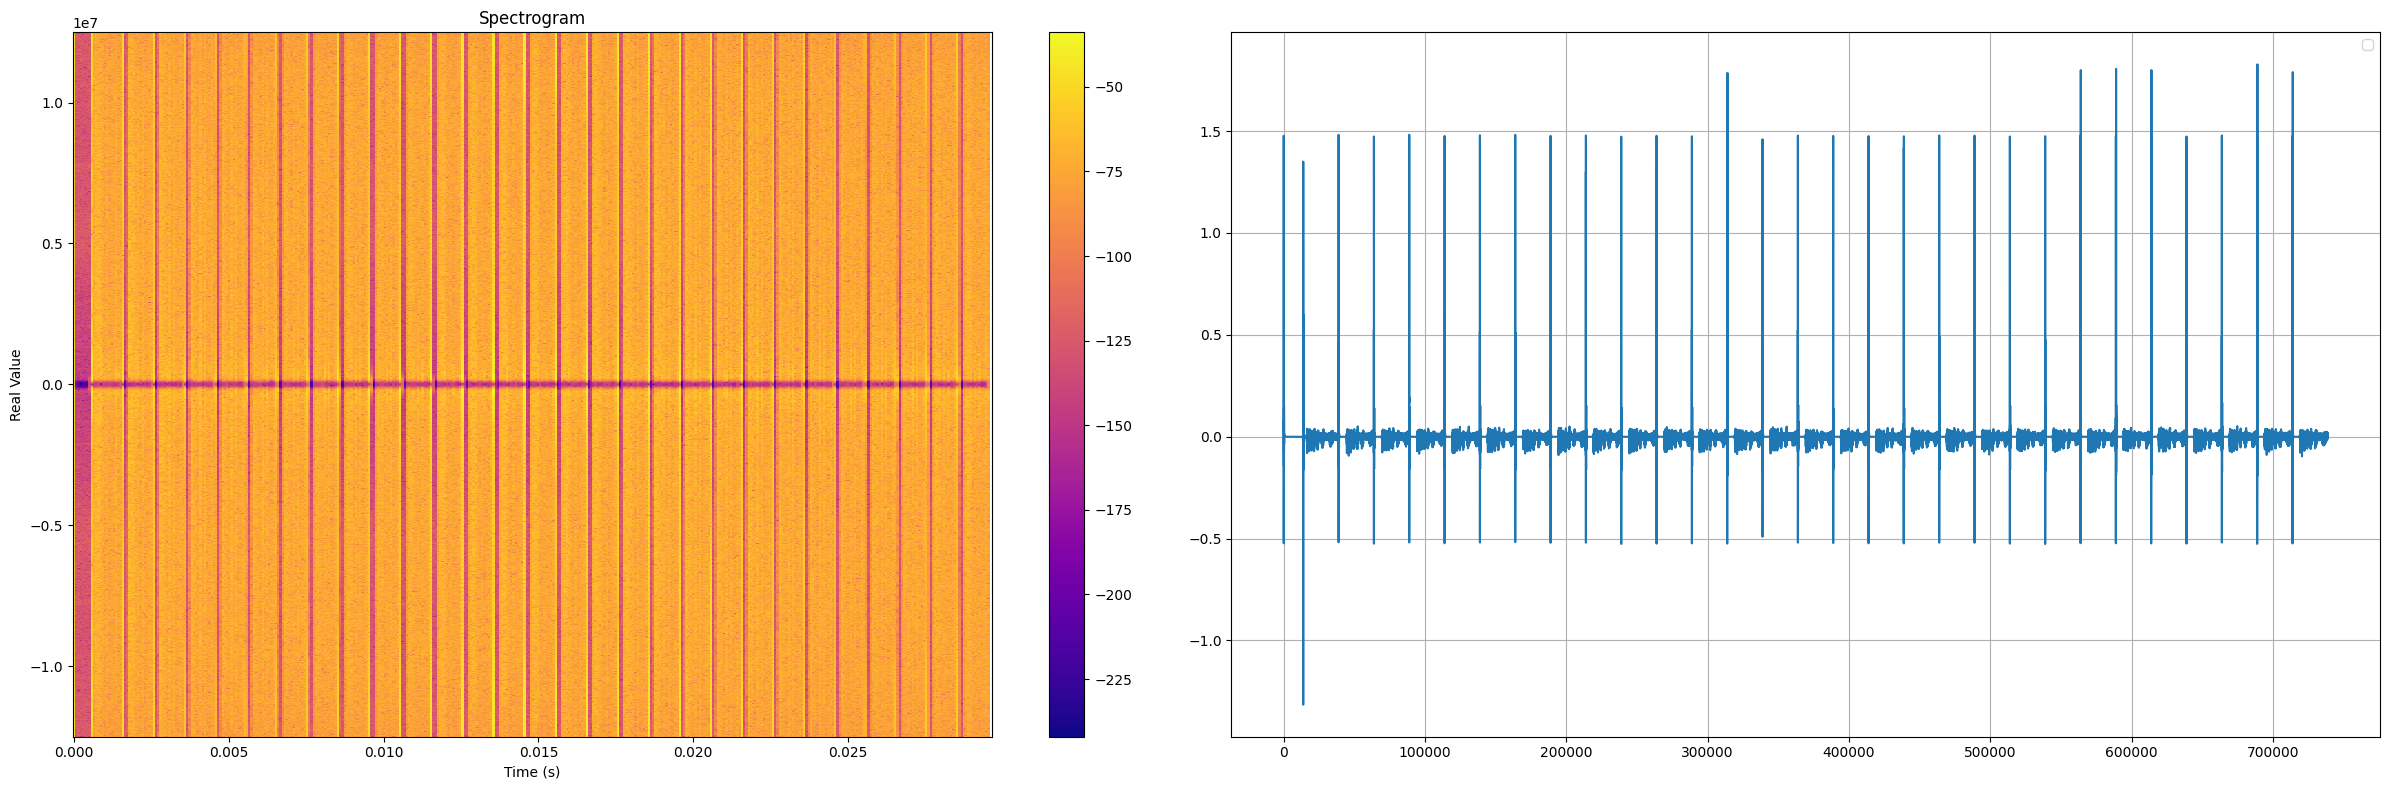

In [44]:
directory = "frames"
frames = []
fs = 25e6

frames = get_frame_array(directory)


# combine all frames
combined_frames = np.concatenate(frames)
combined_frames = notch_filter(combined_frames,fs)


fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(combined_frames,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Real Value')
axs[0].set_title('Spectrogram')



axs[1].plot(combined_frames)
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()
